# Dis 13: Convolutional Neural Networks

CS189 Fall 2020  
Please feel free to use the Zoom function to call for help or create a queue in [https://oh.eecs189.org/](https://oh.eecs189.org/).  
This discussion goes over the convolution operator, what a filter captures and how to handcraft one, the concept of weight sharing, and visualization in neural networks.

In [1]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import os
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive

Install CV2 (OpenCV for Python) for loading images.

In [2]:
!pip install opencv-python
import cv2

Install PyTorch if needed. This might take some time.

In [3]:
!pip install torch torchvision
import torch

## Part (a): Convolution
(5 mins)

For a starter, let's consider convolution in one dimension. Convolution can be viewed as a function that takes a signal $I$ and a mask $G$ (also called _filter_ or _kernel_), and the discrete convolution at point $t$ of the signal with the mask is
$$
(I ∗ G)[t] = \sum_{k=-\infty}^\infty I[k]G[t − k]
$$
If the mask $G$ is nonzero in only a finite range, then the summation can be reduced to just the range in which the mask is nonzero, which makes computing a convolution on a computer possible. The animation below illustrates this operation.

<img src="1dconv.gif" width=400 height=400/>

(Figure 1: [source](https://e2eml.school/convolution_one_d.html))

As an example, we can use convolution to compute a derivative approximation with finite differences. The derivative approximation of the signal is $I′[t] \approx (I[t + 1] − I[t − 1])/2$. **Design a mask $G$ such that $(I ∗ G)[t] \approx I′[t]$.** 

**Your answer:**
<br/><br/><br/><br/>

SOLUTION:  
$G[-1] = -1/2, G[0] = 0, G[1] = 1/2$ and the remaining entries are zero, or 
$$
G = \begin{bmatrix}
-1/2 & 0 & +1/2
\end{bmatrix}
$$

---

The convolution operator can be extended to an input of arbitrary dimension. For example, 2D inputs or images have the following form: 
$$
(I ∗ G)[x, y] = \sum_{k=-\infty}^\infty \sum_{l=-\infty}^\infty I[k, l]G[x − k, y - l]
$$

The animation shows the input (blue), the output (green), and the 3x3 flipped filter "sliding" through the input:

<img src="2dconv.gif" width=300 height=300/>

(Figure 2: [source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1))


The type of mask that we came up with earlier is often used to compute _image gradient_ (not to be confused with gradient descent) which is heavily used in image processing and, particularly, edge detection. _Sobel filter_ is one of the most popular, and it has the following form:

$$
G_x = \begin{bmatrix} 
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{bmatrix}
\quad \mathrm{and} \quad
G_y = \begin{bmatrix} 
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}
$$

[//]: # (**What kind of pattern do you think this filter will get the largest response from when we convolve it with an image?** In other words, think of a 3x3 patch with each pixel between 0 and 1 that maximizes the output of the convolution.

**Your answer:**
<br/><br/><br/><br/>)

You should see that this filter is similar to the finite difference approximation above. The filters are used to detect **a vertical and a horizontal edge**, respectively. See the figure below showing the convolution output of the Sobel filters for vertical (bottom right) and horizontal (bottom left) gradients and the magnitude of the gradients (top right). Notice the brick pattern.

<img src="sobel.png" width=500 height=500/>

(Figure 3: [source](https://en.wikipedia.org/wiki/Sobel_operator))

This operation is one of the steps in _Canny edge detection algorithm_ proposed by Professor John Canny (our current CS chair!) in 1986.

[//]: # "Suppose we The output is maximized and minimized (most negative) with the input being 

$$
\begin{bmatrix} 
0 & a & 1 \\
0 & b & 1 \\
0 & c & 1
\end{bmatrix}
\quad \mathrm{and} \quad
\begin{bmatrix} 
1 & a & 0 \\
1 & b & 0 \\
1 & c & 0
\end{bmatrix}
\quad \mathrm{respectively}
$$

where $a$, $b$, and $c$ can be any arbitrary constant."

---

## Part (b): Convolutional neural networks
(10 mins)

In this part, we will implement a 2D convolution for an image input with only one color channel (grayscale).
Note that technically the filter must be flipped along both axes by the convolution operation, but from this point onwards, we will use the neural network convention where the flipping is ignored. 

- **Suppose our input image has a size of 40x40, what is the output size after convolving it with a kernel of size 5x5 with no padding and stride set to 1?**

**Your answer:**
<br/><br>

SOLUTION: $36 \times 36$

- **More generally, let the input size be $h$ by $h$ and the kernel size be $k$ by $k$, what is the output size in terms of $h$ and $k$?** You may assume that $k$ is an odd number.

**Your answer:**
<br/><br>

SOLUTION: $(h - k + 1) \times (h - k + 1)$

Sometimes we can save computation and take a bigger step when sliding the kernel through the input. This is what _stride_ means. For the convolution we have seen so far, the stride is 1. When the stride is 2, we skip one pixel when sliding the kernel. See the animation below.

<img src="stride.gif" width=300 height=300/>

(Figure 4: [source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1))

Without the stride, the output size would have been 3x3, but in this case, the output size is only 2x2. Roughly, for a stride $s$, the output size is scaled down by a factor of $s$. Using strides saves computation by reducing the number of arithmetic operations as well as the size of the output, which is passed along to the next layer. 

- **What is the output size in terms of $h$, $k$ and $s$?** (skip this if you are running out of time)

**Your answer:**
<br/><br>

SOLUTION: $a \times a ~\mathrm{where}~ a = \left\lfloor \frac{h - k}{s} \right\rfloor + 1$ or $\left\lceil \frac{h - k + 1}{s} \right\rceil$


---

**Next, implement the 2d convolution function below.** 

In [4]:
def conv2d(inpt, kernel, stride):
    """
    inpt:   (np.array) input, shape = [height, width, channels]
    kernel: (np.array) kernel for convolution (already flipped), 
            shape = [kernel_height, kernel_width, channels]
    stride: (int) stride for both x and y directions
    """
    assert inpt.ndim == 3
    assert kernel.ndim == 3
    assert inpt.shape[-1] == kernel.shape[-1]
    
    height = np.floor((inpt.shape[0] - kernel.shape[0]) / stride) + 1
    width = np.floor((inpt.shape[1] - kernel.shape[1]) / stride) + 1
    height, width = int(height), int(width)
    output = np.zeros((height, width))
    
    for h in range(height):
        for w in range(width):
            ### start convolution ###
            output[h, w] = np.sum(inpt[
                h * stride : h * stride + kernel.shape[0], 
                w * stride : w * stride + kernel.shape[1]] * kernel)
            ### end convolution ###
    
    return output

def show_img(img, figsize=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    if img.ndim == 2:
        h, w = img.shape
    elif img.ndim == 3:
        h, w, _ = img.shape
    else:
        raise AttributeError('Wrong image dimension.')
    ax = plt.gca()
    if np.any(img < 0):
        # Plot heatmap for response maps or filters
        plt.imshow(img.reshape(h, w), cmap='hot', interpolation='nearest')
        plt.colorbar()
    else:
        # Plot image normally
        plt.imshow(img.reshape(h, w), cmap='gray')
    ax.set_xticks(np.arange(-.5, h, 1))
    ax.set_yticks(np.arange(-.5, w, 1))
    ax.set_xticklabels(np.arange(h + 1), fontsize=10)
    ax.set_yticklabels(np.arange(w + 1), fontsize=10)
    plt.grid()
    plt.show()

Now let's try to apply it to the image below. **What pattern is `kernel1` and `kernel2` below trying to detect? Is the output expected?** Try changing `stride` as well.

**Your answer:**
<br/><br/><br/><br/>

SOLUTION: `kernel1` is detecting a horizontal line, and `kernel2` is detecting a vertical line.

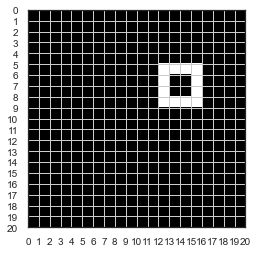

In [5]:
img = np.zeros((20, 20, 1))
img[5:9, 12:16] = 1
img[6:8, 13:15] = 0
show_img(img)

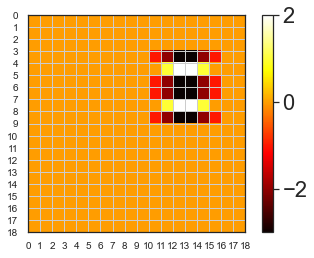

In [6]:
kernel1 = np.array([[-1, -1, -1],
                    [ 1,  1,  1],
                    [-1, -1, -1]])
# Reshape to 3x3x1
kernel1 = kernel1[:, :, np.newaxis]
# Set stride here
stride = 1

out = conv2d(img, kernel1, stride)
show_img(out)

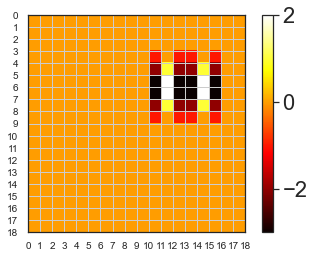

In [7]:
kernel2 = np.array([[-1, 1, -1],
                    [-1, 1, -1],
                    [-1, 1, -1]])
# Reshape to 3x3x1
kernel2 = kernel2[:, :, np.newaxis]
# Set stride here
stride = 1

out = conv2d(img, kernel2, stride)
show_img(out)

---

## Part (c): Design your own filter
(15 mins)

The example above shows one way to detect horizontal and vertical edges that can be combined to detect the square. Now we will try a different set of filters by using **two** convolutional layers. 

Generally speaking, for image data or data with 2D structure plus one extra dimension for channels (total of three dimensions), each convolutional layer maps 3D input with shape `[in_height, in_width, in_channels]` to 3D output with shape `[out_height, out_width, out_channels]`. The corresponding filter is a 4D tensor with shape `[kernel_height, kernel_width, in_channels, out_channels]`. 

This may seem confusing at first, but you can briefly forget about all the `height` and `width` dimensions, and you will see that this is just like a fully connected layer where the weight has shape of `[in_dim, out_dim]`. Similarly to a single parameter in a fully connected layer, each 2D kernel maps one channel of the input to one channel of the output. Thus, you will need `in_dim x out_dim` of these kernels, and whatever maps to the same output channel gets summed together like one neuron. 

The animation below gives an example of a convolution layer with 3-channel input and 2-channel output. You can see that there are $3 \times 2 = 6$ of these little 2D kernels, and the outputs of three of them (`Filter W0` or `Filter W1`) are summed up to produce one of the two output channels.

<img src="4d.gif" width=600 height=600/>

(Figure 5: If you'd like to pause the animation and verify the calculation, please see the [source](https://cs231n.github.io/convolutional-networks/))

Another way to visual this process is to see the input and the kernel as a 3D volume or a cube with the same number of channels or depth. With the figure below, the kernel is slided through the input with the 2D convolution, producing one channel of the output. To produce $c$-channel outputs, we need $c$ of these 3D kernels.

<img src="3d.gif" width=300 height=300/>

(Figure 6: [source](https://predictiveprogrammer.com/famous-convolutional-neural-network-architectures-1/))

Once you feel comfortable with the concept of multiple channels. Let's try to apply it. **Design 2 convolutional layers to detect the 4x4 squares in the given image (grayscale or one channel) under the following conditions:**
- The first layer will have 4 3x3 kernels (or a 3x3 kernel with 4 channels) to detect the 4 corners of the 4x4 sqaure. A corner is an 'L' shape with height and width of 3 pixels (think about why a smaller 2x2 corner does not work with the second layer with 2x2 kernels). With the notation above, the kernel size is `[3, 3, 1, 4]`.
- Then, the second layer has 4 2x2 kernels applied on top of the outputs from the first layer and sums them up to 1 channel. The kernel size is `[2, 2, 4, 1]`.
- Just use $-1$, $0$, or $1$ to set the weights in the kernels.
- For simplicity, we will also use a ReLU activation function with some fixed bias (4.5) on the first layer. Stride is set to 1.

Below is the shape of the input and the outputs we are working with:

$$
\textrm{Input:} [32 \times 32 \times 1] \to \textrm{Output1:} [30 \times 30 \times 4] \to \textrm{Output2:} [29 \times 29 \times 1]
$$

You have to think about how to detect the corners such that only the 2x2 kernels are sufficient for combining them. Below is the given image.

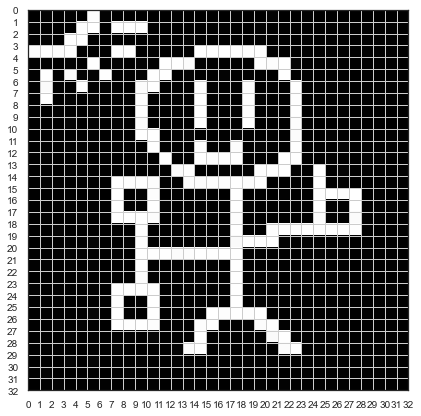

In [8]:
img = 1 - cv2.imread("stick.jpg").mean(-1, keepdims=True) / 255.
show_img(img, (7, 7))

**Fill in filters for the first layer: `k11, k12, k13, k14`.**

When you run the cell, you should see the filters you designed (top row), the convolution output (middle row), and the output after ReLU (bottom row). You should only see a few dots (about 6 - 7) in each of the four outputs in the bottom row. This is the expected output on the bottom row.

<img src="partc1.png" width=500 height=500/>

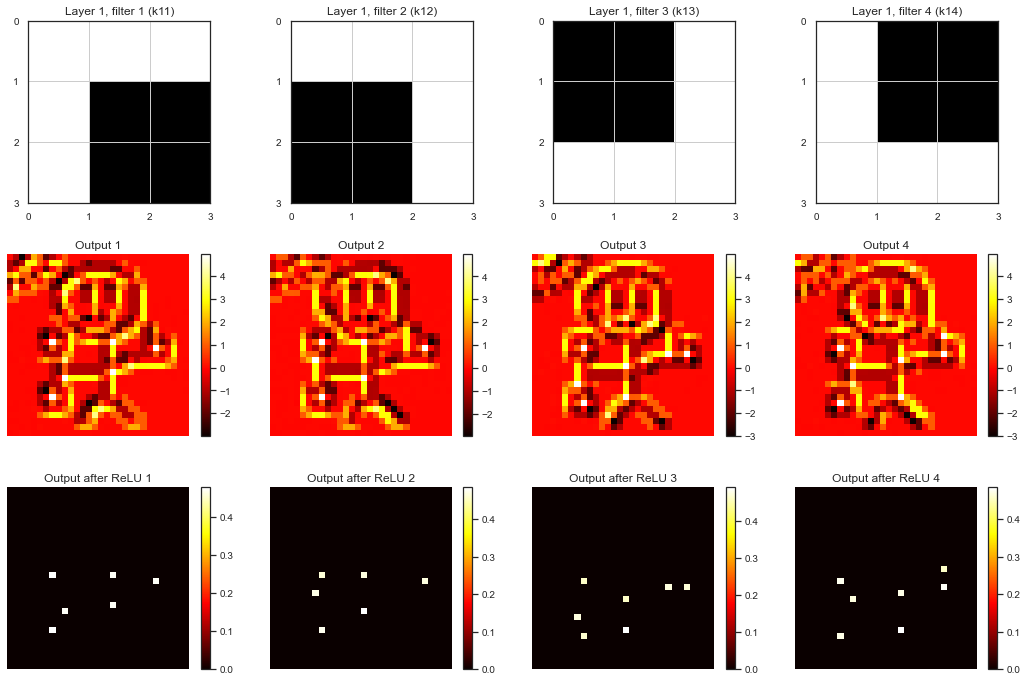

In [9]:
# Fill in these four filters (starter code)
k11 = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
k12 = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
k13 = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
k14 = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]

### start first_layer ###
# Solution with 0's
k11 = [[1, 1, 1],
       [1, 0, 0],
       [1, 0, 0]]
k12 = [[1, 1, 1],
       [0, 0, 1],
       [0, 0, 1]]
k13 = [[0, 0, 1],
       [0, 0, 1],
       [1, 1, 1]]
k14 = [[1, 0, 0],
       [1, 0, 0],
       [1, 1, 1]]
# Solution with -1's
k11 = [[1,  1,  1],
       [1, -1, -1],
       [1, -1, -1]]
k12 = [[ 1,  1, 1],
       [-1, -1, 1],
       [-1, -1, 1]]
k13 = [[-1, -1, 1],
       [-1, -1, 1],
       [ 1,  1, 1]]
k14 = [[1, -1, -1],
       [1, -1, -1],
       [1,  1,  1]]
### end first_layer ###

out1 = []
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i, kernel in enumerate([k11, k12, k13, k14]):
    # Convolution
    output = conv2d(img, np.array(kernel)[:, :, np.newaxis], 1)
    # ReLU activation
    output_relu = np.maximum(output - 4.5, 0)
    out1.append(output_relu)
    
    # Plot
    axs[0, i].imshow(kernel, cmap='gray')
    axs[0, i].set_xticks(np.arange(-.5, 3, 1))
    axs[0, i].set_yticks(np.arange(-.5, 3, 1))
    axs[0, i].set_xticklabels(np.arange(4), fontsize=10)
    axs[0, i].set_yticklabels(np.arange(4), fontsize=10)
    axs[0, i].grid()
    axs[0, i].set_title('Layer 1, filter %d (k1%d)' %
                        (i + 1, i + 1), fontsize=12)
    
    im1 = axs[1, i].imshow(output, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(im1, ax=axs[1, i])
    cbar.ax.tick_params(labelsize=10)
    axs[1, i].axis('off')
    axs[1, i].set_title('Output %d' % (i + 1), fontsize=12)
    
    im2 = axs[2, i].imshow(output_relu, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(im2, ax=axs[2, i])
    cbar.ax.tick_params(labelsize=10)
    axs[2, i].axis('off')
    axs[2, i].set_title('Output after ReLU %d' % (i + 1), fontsize=12)
plt.tight_layout()

**Now fill in the filter for the second layer `k2`.**

You may write out each individual 2x2 filter as before or just set some of the weights to $1$. After running the code, you should see three high responses at the locations of the three squares. This is the expected output.

<img src="partc2.png" width=300 height=300/>

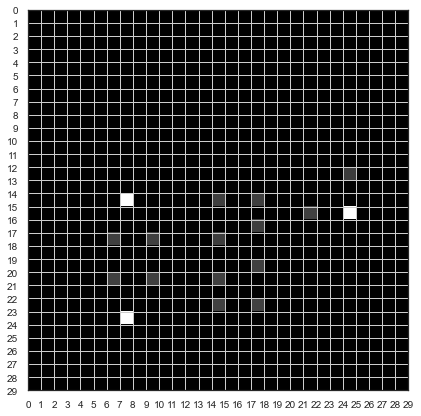

In [10]:
k2 = np.zeros((2, 2, 4))
### start second_layer ###
k2[0, 0, 0] = 1
k2[0, 1, 1] = 1
k2[1, 1, 2] = 1
k2[1, 0, 3] = 1
### end second_layer ###

out2 = 0
for i, inpt in enumerate(out1):
    out2 += conv2d(inpt[:, :, np.newaxis], k2[:, :, i:i + 1], 1)
    
show_img(out2, (7, 7))

Notes
- We have seen a way to handcraft features or patterns of interest. In neural networks and deep learning, the filters are "learned" or optimized through gradient descent and backpropgation in the same way as the fully connected layers that you have seen earlier.
- This is an example of how early layers detect low-level features such as lines and edges, and the later layers combine this low-level information to locate a high-level pattern such as faces, textures, or a square in this case. We will see in part (e) that this structure is also somtimes learned by neural networks.

---

## Part (d) : Why convolutional layers?
(5 min)

Now we will look into the motivation behind convolutional layers and how they are different from the fully connected layers. 

### Translational invariance
From the previous part, we should have seen that the convolutional layer is very convenient for locating recurring patterns that present anywhere in the image. This property is often referred to as _translational invariance_ or _shift invariance_. This property is automatically enforced by convolutional layers but not by fully connected layers. This design choice or "architectural" choice can be regarded as a way humans impose their prior knowledge of the data into building the models. This assumption is particularly suitable to image data. For example, a dog move to the right by three pixels is still a dog. No semantic meaning is changed by translation.

### Weight sharing
Let's consider the example above with 32x32-pixel inputs and 3x3 kernel with four channels. Suppose that we want to use a fully connected layer to imitate this convolutional layer. Given a fixed input and an output (forget about invariance for now), **how many parameters do we need in the fully connected layer?** **How does it compare to those of the convolutional layer?** You should see that the convolutional layer requires much fewer parameters which save computational costs and prevent overfitting.

**Your answer:**
<br/><br/><br/><br/>

SOLUTION:

Fully connected: The output size or the number of neurons is $30 \times 30 \times 4$. Each neuron is connected to a patch of size $3 \times 3 \times 1$. So the total number of parameters is $30 \times 30 \times 4 \times 3 \times 3 = 32400$.   
Convolutional: $3 \times 3 \times 4 = 36$.

---

## Part (e): Feature visualization
(5 min)

### Kernel visualization

We will first visualize the weights in the kernels of a large neural network trained on the ImageNet dataset. We will be using PyTorch.

Build AlexNet on CPU with randomly initialized weights and take only its feature extraction part.

In [11]:
from alexnet import alexnet
net = alexnet(False).features.eval().cpu()

# This is another network you can play around with
# from vgg import vgg16
# net = vgg16(False).features.eval().cpu()

Examine the architecture of the network.

In [12]:
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

We are interested in the feature extraction part. It is a `Sequential` object so you can iterate through each layer just like a list.

In [13]:
net[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

Now we can examine the parameters (`weight` and `bias`) in each layer and its shape. For convolutional layers, `weight` has shape `[output_channels, input_channels, kernel_height, kernel_width]`.

In [14]:
print(net[0].weight.shape)
print(net[0].bias.shape)

torch.Size([64, 3, 11, 11])
torch.Size([64])


Let's plot the weights of a few filters from the first layer. Since the first layer has three input channels, we can visualize it as color images.

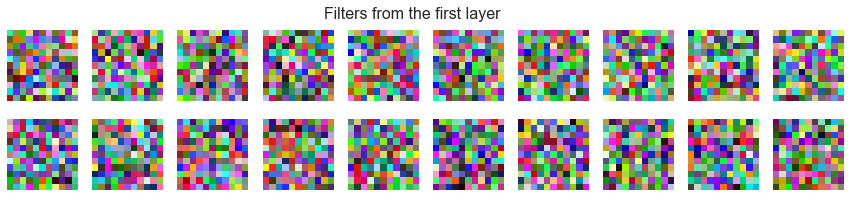

In [15]:
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i, weight in enumerate(net[0].weight[:20]):
    kernel = weight.detach().numpy()
    # Move the channel dimension to last
    kernel = np.moveaxis(kernel, 0, -1)
    # Scale to range [0, 1]
    kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
    axs[i // 10, i % 10].imshow(kernel)
    axs[i // 10, i % 10].axis('off')
fig.suptitle('Filters from the first layer', fontsize=16)
plt.show()

Plot deeper layers. **Pick other convolutional layers by changing `layer`.**

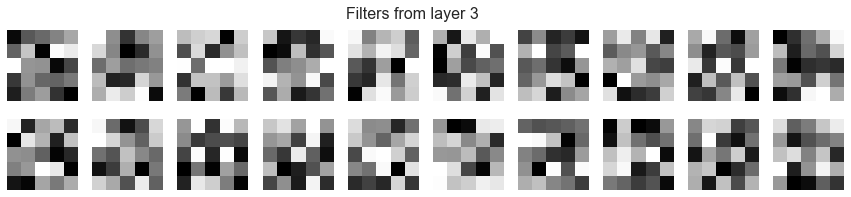

In [16]:
# Select a convolutional layer from the indices we printed out earlier
layer = 3   # This is the second convolutional layer. Try 3, 6, 8, 10.

fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i, weight in enumerate(net[layer].weight[:20]):
    kernel = weight[0].detach().numpy()
    # Scale to range [0, 1]
    kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
    axs[i // 10, i % 10].imshow(kernel, cmap='gray')
    axs[i // 10, i % 10].axis('off')
fig.suptitle('Filters from layer %d' % layer, fontsize=16)
plt.show()

Now we will build AlexNet with pre-trained weights and examine its weights again.

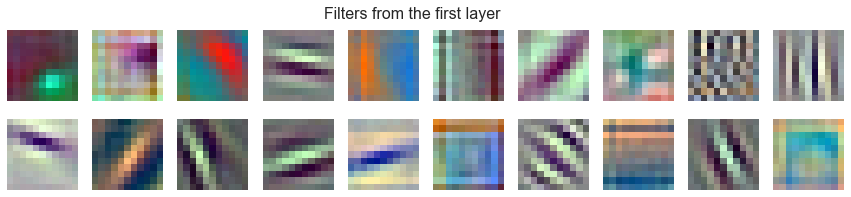

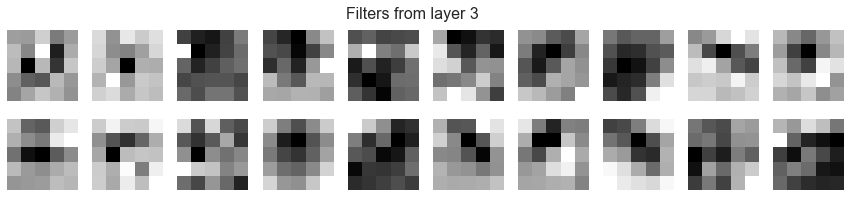

In [17]:
# Build alexnet with pretrained weights
net = alexnet(True).features.eval().cpu()

fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i, weight in enumerate(net[0].weight[:20]):
    kernel = weight.detach().numpy()
    # Move the channel dimension to last
    kernel = np.moveaxis(kernel, 0, -1)
    # Scale to range [0, 1]
    kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
    axs[i // 10, i % 10].imshow(kernel)
    axs[i // 10, i % 10].axis('off')
fig.suptitle('Filters from the first layer', fontsize=16)
plt.show()
    
layer = 3   # This is the second convolutional layer

fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i, weight in enumerate(net[layer].weight[:20]):
    kernel = weight[0].detach().numpy()
    # Scale to range [0, 1]
    kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
    axs[i // 10, i % 10].imshow(kernel, cmap='gray')
    axs[i // 10, i % 10].axis('off')
fig.suptitle('Filters from layer %d' % layer, fontsize=16)
plt.show()

**Do you notice any difference between the randomly initialized and the pre-trained weights?**

**Your answer:**
<br/><br><br/><br>

SOLUTION: The kernels of the fully trained network look less random and show obvious features that they are detecting or responding to, especially the first layer.

Feel free to go back, load VGG model instead, and play around with it. The features are not as obvious there, but they are still pretty interesting to see.

### Response maps

We can also visualize the response maps or the activations of each convolutional layer. This what you were asked to do in HW13 Q2(d), but here, the network structure is different so the code will also be different. There are also multiple ways to fetch the response maps. This is the way that creates a wrapper (`FeatureVis`) and does not require modifying the original network object, though a bit more complicated.

In [18]:
class FeatureVis(torch.nn.Module):

    def __init__(self, net, layer):
        """
        net:   (torch.nn.Sequential) base network
        layer: (int) layer to get response map from
        """
        assert layer > 0
        super(FeatureVis, self).__init__()
        self.net = net
        self.layer = layer
        
    def forward(self, x):
        out = self.net[0](x)
        for i in range(self.layer - 1):
            out = self.net[i + 1](out)
        return out
    
# Function for loading and preprocessing images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def load_images_from_folder(folder):
    images = []
    images_orig = []
    for filename in os.listdir(folder):
        if not 'n0' in filename:
            continue
        img = cv2.imread(os.path.join(folder, filename)) 
        if img is not None:         
            # Convert to RGB and normalize to [0, 1]
            img = img[:,:,::-1] / 255.
            # Resize to 224x224
            img = cv2.resize(img, (224, 224))
            images_orig.append(img)
            # Standardization
            images.append((img - mean) / std)
    images = np.moveaxis(np.array(images), -1, 1)
    images = torch.from_numpy(images).float()
    return images, images_orig

# Function for plotting
def plot_response_maps(img_index):
    # Plot image
    plt.imshow(imgs_orig[img_index])
    plt.axis('off')
    plt.title('Original image', fontsize=16)
    plt.show()

    # Plot the response maps
    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i, resp in enumerate(responses[img_index][:20]):
        resp = resp.detach().numpy()
        # Scale to range [0, 1]
        resp = (resp - resp.min()) / (resp.max() - resp.min())
        axs[i // 10, i % 10].imshow(resp, cmap='gray')
        axs[i // 10, i % 10].axis('off')
    fig.suptitle('Responses maps', fontsize=16)
    
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=11,
    step=1,
    description='Image:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [19]:
# Set layer you want to examine here (1, 4, 7)
layer = 1

vis = FeatureVis(net, layer)
imgs, imgs_orig = load_images_from_folder('./')
responses = vis(imgs)

interactive_plot = interactive(plot_response_maps, img_index=slider)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=11), Output()), _d…

**What are the differences between "shallow" and "deep" response maps?**

**Your answer:**
<br/><br><br/><br>

SOLUTION: Response maps from a deeper layer has lower resolution and looks less similar to the original image. The deeper responses potentially show higher-level features being detected.

### Other visualization techniques 

Use backpropagated gradients to visualize important features or parts of the inputs. Historically, this also directly connected to and inspired adversarial examples (see the original paper on adversarial examples on neural networks [link](https://arxiv.org/pdf/1312.6199.pdf)).

- Guided backpropagation ([link](https://arxiv.org/pdf/1412.6806.pdf)): 

<img src="guidebprop.png" width=500 height=500/>

- Grad-CAM and Guided Grad-CAM ([link](https://arxiv.org/pdf/1610.02391.pdf)):

<img src="visual.png" width=500 height=500/>

### Texture bias

Recent research finds that sometimes neural networks do not learn the features that we expect or features that humans do not necessarily use to the same prediction. Geirhos et al. (2019) ([link](https://openreview.net/pdf?id=Bygh9j09KX)) shows that neural networks are biased towards textures for classification rather than shapes or outlines.

<img src="texture.png" width=500 height=500/>